## Seq2seq models and attention

This time we'll solve a problem of transribing hebrew words in english, also known as g2p (grapheme2phoneme)

 * word (sequence of letters in source language) -> translation (sequence of letters in target language)


### About the task

One notable property of Hebrew is that it's consonant language. That is, there are no wovels in the written language. One could represent wovels with diacritics above consonants, but you don't expect people to do that in everyay life.

Therefore, some hebrew characters will correspond to several english letters and others - to none, so we should use encoder-decoder architecture to figure that out.

![img](https://esciencegroup.files.wordpress.com/2016/03/seq2seq.jpg)
_(img: esciencegroup.files.wordpress.com)_

Encoder-decoder architectures are about converting anything to anything, including
 * Machine translation and spoken dialogue systems
 * [Image captioning](http://mscoco.org/dataset/#captions-challenge2015) and [image2latex](https://openai.com/requests-for-research/#im2latex) (convolutional encoder, recurrent decoder)
 * Generating [images by captions](https://arxiv.org/abs/1511.02793) (recurrent encoder, convolutional decoder)
 * Grapheme2phoneme - convert words to transcripts
  
We chose simplified __Hebrew->English__ machine translation for words and short phrases (character-level), as it is relatively quick to train even without a gpu cluster.

In [1]:
! wc ../he-en/en.train.txt

 496000  496000 4020284 ../he-en/en.train.txt


In [2]:
!wc ../he-en/he.train.txt

 496000  496000 5841734 ../he-en/he.train.txt


In [3]:
with open('../he-en/en.train.txt') as f, open('../he-en/he.train.txt') as g, open('en_he.train.txt', 'w') as out:
    for en, he in zip(f, g):
        out.write(en.strip() + '\t' + he.strip() + '\n')

In [4]:
!ls ../he-en/

en.dev.txt   en.train.txt  he.test.txt	 hewv.dev.txt	hewv.train.txt
en.test.txt  he.dev.txt    he.train.txt  hewv.test.txt	hewv.txt


In [5]:
with open('../he-en/en.dev.txt') as f, open('../he-en/he.dev.txt') as g, open('en_he.dev.txt', 'w') as out:
    for en, he in zip(f, g):
        out.write(en.strip() + '\t' + he.strip() + '\n')

In [6]:
with open('../he-en/en.test.txt') as f, open('../he-en/he.test.txt') as g, open('en_he.test.txt', 'w') as out:
    for en, he in zip(f, g):
        out.write(en.strip() + '\t' + he.strip() + '\n')

In [7]:
with open('../he-en/he.train.txt') as f, open('../he-en/hewv.train.txt') as g, open('he_hewv.train.txt', 'w') as out:
    for en, he in zip(f, g):
        out.write(en.strip() + '\t' + he.strip() + '\n')

In [8]:
with open('../he-en/he.dev.txt') as f, open('../he-en/hewv.dev.txt') as g, open('he_hewv.dev.txt', 'w') as out:
    for en, he in zip(f, g):
        out.write(en.strip() + '\t' + he.strip() + '\n')

In [9]:
with open('../he-en/he.test.txt') as f, open('../he-en/hewv.test.txt') as g, open('he_hewv.test.txt', 'w') as out:
    for en, he in zip(f, g):
        out.write(en.strip() + '\t' + he.strip() + '\n')

In [10]:
all_data = []

with open('he_hewv.train.txt', 'r') as f:
    all_data += [l.strip() for l in f]
with open('he_hewv.dev.txt', 'r') as f:
    all_data += [l.strip() for l in f]
with open('he_hewv.test.txt', 'r') as f:
    all_data += [l.strip() for l in f]

with open('main_dataset.txt', 'w') as f:
    f.write('\n'.join(all_data))

In [11]:
EASY_MODE = True        #If True, only translates phrases shorter than 20 characters (way easier).
                        #Useful for initial coding.
                        #If false, works with all phrases (please switch to this mode for homework assignment)

MODE = "he-to-en"                                #way we translate. Either "he-to-en" or "en-to-he"
MAX_OUTPUT_LENGTH = 50 if not EASY_MODE else 20  #maximal length of _generated_ output, does not affect training
REPORT_FREQ       = 100                          #how often to evaluate validation score

### Step 1: preprocessing

We shall store dataset as a dictionary
`{ word1:[translation1,translation2,...], word2:[...],...}`.

This is mostly due to the fact that many words have several correct translations.

We have implemented this thing for you so that you can focus on more interesting parts.


__Attention python2 users!__ You may want to cast everything to unicode later during homework phase, just make sure you do it _everywhere_.

In [12]:
import numpy as np
from collections import defaultdict
word_to_translation = defaultdict(list) #our dictionary

bos = '_'
eos = ';'

with open("main_dataset.txt") as fin:
    for line in fin:
        
        en,he = line[:-1].lower().replace(bos,' ').replace(eos,' ').split('\t')
        word,trans = (he,en) if MODE=='he-to-en' else (en,he)
        
        if len(word) < 3: continue
        if EASY_MODE:
            if max(len(word),len(trans))>20:
                continue
        
        word_to_translation[word].append(trans)
    
print ("size = ",len(word_to_translation))

('size = ', 326864)


In [13]:
#get all unique lines in source language
all_words = np.array(list(word_to_translation.keys()))
# get all unique lines in translation language
all_translations = np.array([ts for all_ts in word_to_translation.values() for ts in all_ts])


### split the dataset

We hold out 10% of all words to be used for validation.


In [14]:
from sklearn.model_selection import train_test_split
train_words,test_words = train_test_split(all_words,test_size=0.1,random_state=42)

### Building vocabularies

We now need to build vocabularies that map strings to token ids and vice versa. We're gonna need these fellas when we feed training data into model or convert output matrices into english words.

In [15]:
from voc import Vocab
inp_voc = Vocab.from_lines(''.join(all_words), bos=bos, eos=eos, sep='')
out_voc = Vocab.from_lines(''.join(all_translations), bos=bos, eos=eos, sep='')

In [16]:
# Here's how you cast lines into ids and backwards.
batch_lines = all_words[:5]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['\xd7\x95\xd7\x92\xd6\xb6\xd7\x96'
 '\xd7\xa9\xd7\x81\xd6\xb7\xd7\x9c\xd7\x95\xd7\x94'
 '\xd7\x95\xd7\x92\xd6\xb6\xd7\x95'
 '\xd7\x93\xd6\xbc\xd6\xb0\xd7\xa2\xd6\xb9\xd7\xa0\xd6\xb6\xd7\x92'
 '\xd7\x95\xd7\x92\xd6\xb6\xd7\x93']

words to ids (0 = bos, 1 = eos):
[[ 0 55 13 55 12 56 47 55 16  1  1  1  1  1  1  1  1  1]
 [ 0 55 33 55  2 56 46 55 22 55 13 55 14  1  1  1  1  1]
 [ 0 55 13 55 12 56 47 55 13  1  1  1  1  1  1  1  1  1]
 [ 0 55 11 56 52 56 42 55 28 56 48 55 26 56 47 55 12  1]
 [ 0 55 13 55 12 56 47 55 11  1  1  1  1  1  1  1  1  1]]

back to words
['\xd7\x95\xd7\x92\xd6\xb6\xd7\x96', '\xd7\xa9\xd7\x81\xd6\xb7\xd7\x9c\xd7\x95\xd7\x94', '\xd7\x95\xd7\x92\xd6\xb6\xd7\x95', '\xd7\x93\xd6\xbc\xd6\xb0\xd7\xa2\xd6\xb9\xd7\xa0\xd6\xb6\xd7\x92', '\xd7\x95\xd7\x92\xd6\xb6\xd7\x93']


Draw word/translation length distributions to estimate the scope of the task.

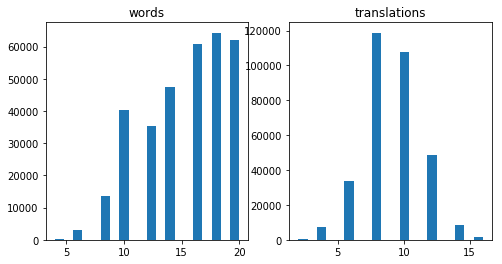

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=[8,4])
plt.subplot(1,2,1)
plt.title("words")
plt.hist(list(map(len,all_words)),bins=20);

plt.subplot(1,2,2)
plt.title('translations')
plt.hist(list(map(len,all_translations)),bins=20);


### Step 2: deploy encoder-decoder (2 points)

__assignment starts here__

Our architecture consists of two main blocks:
* Encoder reads words character by character and outputs code vector (usually a function of last RNN state)
* Decoder takes that code vector and produces translations character by character

Than it gets fed into a model that follows this simple interface:
* __`model.symbolic_translate(inp, **flags) -> out, logp`__ - takes symbolic int32 matrix of hebrew words, produces output tokens sampled from the model and output log-probabilities for all possible tokens at each tick.
* __`model.symbolic_score(inp, out, **flags) -> logp`__ - takes symbolic int32 matrices of hebrew words and their english translations. Computes the log-probabilities of all possible english characters given english prefices and hebrew word.
* __`model.weights`__ - weights from all model layers [a list of variables]

That's all! It's as hard as it gets. With those two methods alone you can implement all kinds of prediction and training.

In [18]:
import tensorflow as tf
tf.reset_default_graph()
s = tf.InteractiveSession()

# ^^^ if you get "variable *** already exists": re-run this cell again

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [19]:
from basic_model import BasicTranslationModel
model = BasicTranslationModel('model',inp_voc,out_voc,
                              emb_size=32, hid_size=64)

# PLEASE DON'T CHANGE THESE VALUES: emb_size=32, hid_size=64

s.run(tf.global_variables_initializer())

Using TensorFlow backend.


In [20]:
# Play around with symbolic_translate and symbolic_score
inp = tf.placeholder_with_default(np.random.randint(0,10,[3,5],dtype='int32'),[None,None])
out = tf.placeholder_with_default(np.random.randint(0,10,[3,5],dtype='int32'),[None,None])

# translate inp (with untrained model)
sampled_out, logp = out,model.symbolic_translate(inp, greedy=False)
print("\nSymbolic_translate output:\n",out,logp)
print("\nSample translations:\n", s.run(sampled_out))

('\nSymbolic_translate output:\n', <tf.Tensor 'PlaceholderWithDefault_1:0' shape=(?, ?) dtype=int32>, (<tf.Tensor 'transpose_1:0' shape=(?, ?) dtype=int32>, <tf.Tensor 'Reshape_1:0' shape=(?, ?, 47) dtype=float32>))
('\nSample translations:\n', array([[1, 7, 4, 1, 9],
       [0, 8, 6, 1, 5],
       [6, 3, 7, 8, 1]], dtype=int32))


In [21]:
# score logp(out | inp) with untrained input
logp = model.symbolic_score(inp,out)
print("\nSymbolic_score output:\n",logp)
print("\nLog-probabilities (clipped):\n", s.run(logp)[:,:2,:5])

('\nSymbolic_score output:\n', <tf.Tensor 'Reshape_3:0' shape=(?, ?, 47) dtype=float32>)
('\nLog-probabilities (clipped):\n', array([[[  0.       , -69.07755  , -69.07755  , -69.07755  ,
         -69.07755  ],
        [ -3.8039947,  -3.8470407,  -3.833827 ,  -3.837545 ,
          -3.84076  ]],

       [[  0.       , -69.07755  , -69.07755  , -69.07755  ,
         -69.07755  ],
        [ -3.7970767,  -3.909302 ,  -3.7687438,  -3.858174 ,
          -3.8886495]],

       [[  0.       , -69.07755  , -69.07755  , -69.07755  ,
         -69.07755  ],
        [ -3.7768872,  -3.8971407,  -3.7901318,  -3.8683689,
          -3.763064 ]]], dtype=float32))


In [22]:
# Prepare any operations you want here
input_sequence = tf.placeholder('int32', [None,None])
greedy_translations, logp = model.symbolic_translate(input_sequence, greedy=True)
    
def translate(lines):
    """
    You are given a list of input lines. 
    Make your neural network translate them.
    :return: a list of output lines
    """
    # Convert lines to a matrix of indices
    lines_ix = inp_voc.to_matrix(lines)

    # Compute translations in form of indices
    trans_ix = s.run(greedy_translations, {input_sequence: lines_ix})

    # Convert translations back into strings
    return out_voc.to_lines(trans_ix)
    

In [23]:
print("Sample inputs:",all_words[:3])
print("Dummy translations:",translate(all_words[:3]))

assert isinstance(greedy_translations,tf.Tensor) and greedy_translations.dtype.is_integer, "trans must be a tensor of integers (token ids)"
assert translate(all_words[:3]) == translate(all_words[:3]), "make sure translation is deterministic (use greedy=True and disable any noise layers)"
assert type(translate(all_words[:3])) is list and (type(translate(all_words[:1])[0]) is str or type(translate(all_words[:1])[0]) is unicode), "translate(lines) must return a sequence of strings!"
print("Tests passed!")

('Sample inputs:', array(['\xd7\x95\xd7\x92\xd6\xb6\xd7\x96',
       '\xd7\xa9\xd7\x81\xd6\xb7\xd7\x9c\xd7\x95\xd7\x94',
       '\xd7\x95\xd7\x92\xd6\xb6\xd7\x95'], dtype='|S20'))
('Dummy translations:', ['\x9e\xb4\xad\xac\xa0\x80\xa5\xb0\xa6\xbe\xa1\xbe\xd7\x93\xe2,\x99\xa9\xa6\xa2\xa1\xa0\xa7\x91\xad\xa5\xaf\xb3', '\xa2\xb4', '\xa5\xb4\xb3\xa1\x96\xd7\x93\xe2\xa6\xbe\xa0\xa3\xd7\xb2\x95\xa2,\x99\xa2\xad\x9a\xa7,\x92\x9b\xa5\x9c\x9c'])
Tests passed!


### Scoring function

LogLikelihood is a poor estimator of model performance.
* If we predict zero probability once, it shouldn't ruin entire model.
* It is enough to learn just one translation if there are several correct ones.
* What matters is how many mistakes model's gonna make when it translates!

Therefore, we will use minimal Levenshtein distance. It measures how many characters do we need to add/remove/replace from model translation to make it perfect. Alternatively, one could use character-level BLEU/RougeL or other similar metrics.

The catch here is that Levenshtein distance is not differentiable: it isn't even continuous. We can't train our neural network to maximize it by gradient descent.

In [24]:
import nltk
bleu_map = lambda reference, hypothesis: nltk.translate.bleu_score.sentence_bleu(word_to_translation[reference], hypothesis)

In [25]:
import editdistance # !pip install editdistance

def get_distance(word,trans):
    """
    A function that takes word and predicted translation
    and evaluates (Levenshtein's) edit distance to closest correct translation
    """
    references = word_to_translation[word]
    assert len(references)!=0,"wrong/unknown word"
    return min(editdistance.eval(trans,ref) for ref in references)

def score(words, bsize=100):
    """a function that computes levenshtein distance for bsize random samples"""
    assert isinstance(words,np.ndarray)
    
    batch_words = np.random.choice(words,size=bsize,replace=False)
    batch_trans = translate(batch_words)
    
    distances = list(map(get_distance,batch_words,batch_trans))
    bleus = list(map(bleu_map, batch_words, batch_trans))
    return np.array(distances,dtype='float32'), np.array(bleus)

In [26]:
#should be around 5-50 and decrease rapidly after training :)
[score(test_words,10)[0].mean() for _ in range(5)]

/home/boyalex/.local/lib/python2.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/home/boyalex/.local/lib/python2.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


[30.4, 26.2, 26.9, 20.3, 23.2]

## Step 3: Training (2 points)

Here we define a function that trains our model through maximizing log-likelihood a.k.a. minimizing crossentropy.

In [27]:
# import utility functions
from basic_model import initialize_uninitialized, infer_length, infer_mask, select_values_over_last_axis

class supervised_training:

    # variable for inputs and correct answers
    input_sequence = tf.placeholder('int32',[None,None])
    reference_answers = tf.placeholder('int32',[None,None])
    
    # Compute log-probabilities of all possible tokens at each step. Use model interface.
    logprobs_seq = model.symbolic_score(input_sequence, reference_answers)
    
    # compute mean crossentropy
    crossentropy = - select_values_over_last_axis(logprobs_seq,reference_answers)
    
    mask = infer_mask(reference_answers, out_voc.eos_ix)
    
    loss = tf.reduce_sum(crossentropy * mask)/tf.reduce_sum(mask)
    
    # Build weights optimizer. Use model.weights to get all trainable params.
    opt = tf.train.AdamOptimizer()
    updates = opt.compute_gradients(loss, model.weights)
    optimizer = opt.apply_gradients(updates)
    train_step = optimizer
    
    
# intialize optimizer params while keeping model intact
initialize_uninitialized(s)

Actually run training on minibatches

In [28]:
import random
def sample_batch(words, word_to_translation, batch_size):
    """
    sample random batch of words and random correct translation for each word
    example usage:
    batch_x,batch_y = sample_batch(train_words, word_to_translations,10)
    """
    #choose words
    batch_words = np.random.choice(words,size=batch_size)
    
    #choose translations
    batch_trans_candidates = list(map(word_to_translation.get,batch_words))
    batch_trans = list(map(random.choice,batch_trans_candidates))
    
    return inp_voc.to_matrix(batch_words), out_voc.to_matrix(batch_trans)

In [29]:
bx,by = sample_batch(train_words, word_to_translation, batch_size=3)
print("Source:")
print(bx)
print("Target:")
print(by)

Source:
[[ 0 55 34 56 47 55 34 56 42 55 24 56 47 55 16  1  1  1  1  1]
 [ 0 55 12 56 47 55 43 55 18 56 45 55 17  1  1  1  1  1  1  1]
 [ 0 55 13 56 42 55 12 56 46 55 11 56 42 55 17 56 47 55 17  1]]
Target:
[[ 0 42 29 42 29 42 19 42 11  1  1  1]
 [ 0 42  7 42 38 42 13 42 12  1  1  1]
 [ 0 42  8 42  7 42  6 42 12 42 12  1]]


In [30]:
hypothesis = ['It', 'is', 'a', 'cat', 'at', 'room']
reference = ['It', 'is', 'a', 'cat', 'inside', 'the', 'room']
#there may be several references
nltk.translate.bleu_score.sentence_bleu([reference], hypothesis)

0.4548019047027907

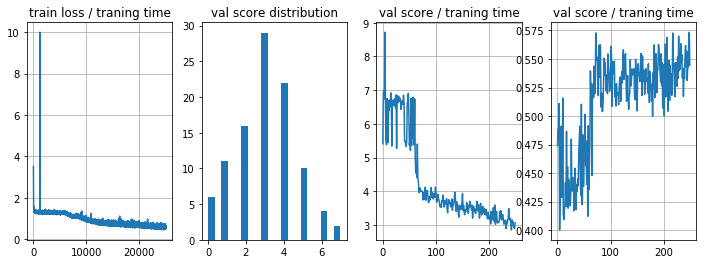

100%|██████████| 25000/25000 [08:17<00:00, 50.24it/s]

llh=0.576, mean score=3.012, mean bleu=0.551


In [31]:
from IPython.display import clear_output
from tqdm import tqdm,trange #or use tqdm_notebook,tnrange

loss_history=[]
editdist_history = []
bleu_history = []

for i in trange(25000):
    bx,by = sample_batch(train_words, word_to_translation, 32)
    
    feed_dict = {
        supervised_training.input_sequence:bx,
        supervised_training.reference_answers:by
    }
    
    loss,_ = s.run([supervised_training.loss,supervised_training.train_step],feed_dict)
    loss_history.append(loss)
    
    if (i+1)%REPORT_FREQ==0:
        clear_output(True)
        current_scores = score(test_words)
        editdist_history.append(current_scores[0].mean())
        bleu_history.append(current_scores[1].mean())
        plt.figure(figsize=(12,4))
        plt.subplot(141)
        plt.title('train loss / traning time')
        plt.plot(loss_history)
        plt.grid()
        plt.subplot(142)
        plt.title('val score distribution')
        plt.hist(current_scores[0], bins = 20)
        plt.subplot(143)
        plt.title('val score / traning time')
        plt.plot(editdist_history)
        plt.grid()
        
        plt.subplot(144)
        plt.title('val score / traning time')
        plt.plot(bleu_history)
        plt.grid()

        plt.show()
        print("llh=%.3f, mean score=%.3f, mean bleu=%.3f"%(np.mean(loss_history[-10:]),np.mean(editdist_history[-10:]), np.mean(bleu_history[-10:])))
        
# Note: it's okay if loss oscillates up and down as long as it gets better on average over long term (e.g. 5k batches)

In [32]:
for word in train_words[:10]:
    print("%s -> %s"%(word,translate([word])[0]))

שיְמֶי -> ברדי
כְמִלְתַא -> ממלות
גַּבֶּךְ -> השך
וְיִדְאַג -> וידרק
עֻמְרִי -> עבוי
לַחֶלֶב -> לחלב
לְתרי -> דחיי
וִידַהַא -> וילוד
דְּבִרְעוּ -> הבחנא
עַנֻגֶּי -> לאלי


In [33]:
test_scores = []
for start_i in trange(0,len(test_words),32):
    batch_words = test_words[start_i:start_i+32]
    batch_trans = translate(batch_words)
    distances = list(map(get_distance,batch_words,batch_trans))
    test_scores.extend(distances)
    
print("Supervised test score:", np.mean(test_scores))

100%|██████████| 1022/1022 [00:09<00:00, 104.02it/s]

('Supervised test score:', 2.9382935111818154)


In [34]:
batch_words[0]

'\xd7\x97\xd6\xb7\xd7\x96\xd7\xa7\xd7\x95'

In [35]:
word_to_translation['\xd7\x97\xd6\xb7\xd7\x96\xd7\xa7\xd7\x95']

['\xd7\x97\xd7\x96\xd7\xa7\xd7\x95']

In [36]:
nltk.translate.bleu_score.sentence_bleu(word_to_translation['\xd7\x97\xd6\xb7\xd7\x96\xd7\xa7\xd7\x95'], 
                                        ('\xd7\x97\xd7\x96\xd7\xa7\xd7\x95'))

1.0

## Step 4: Make it actually work (up to 26 points)

In this section we want you to experiment to find a good model for the task.

**What would be good**:

1) try different recurrent units

2) implement attention - compulsory!

3) try bidirectional rnn/gru/lstm

4) try different functions for attention

5) any other ideas are welcome!

**Requirements**:

1) less than 1.2 llh

2) less than 6 points test score

3) don't change emb_size=32, hid_size=64 (if you're using bidirectional rnn, hid size for each must be 32 to get overall hid_size=64)

**What we expect to get**:

1) results with models in this notebook (top-n models)

2) a brief report describing your experiments and results: what have you tried, why, etc.

**What files you need to send**:

1) this notebook

2) file .py similar to ours basic_model.py with all your models and attentions


Below is the version of attention template: you can use it if you want.

Let's make one joined function to run and evaluate models.

In [37]:
def run_eval(words, training, bsize=100):
    # Prepare any operations you want here
    def translate(lines, training):
        """
        You are given a list of input lines. 
        Make your neural network translate them.
        :return: a list of output lines
        """
        # Convert lines to a matrix of indices
        lines_ix = inp_voc.to_matrix(lines)

        # Compute translations in form of indices
        trans_ix = s.run(training.greedy_translations, {training.input_sequence: lines_ix})

        # Convert translations back into strings
        return out_voc.to_lines(trans_ix)
    
    def score(words, training, bsize=100):
        """a function that computes levenshtein distance for bsize random samples"""
        assert isinstance(words,np.ndarray)

        batch_words = np.random.choice(words,size=bsize,replace=False)
        batch_trans = translate(batch_words, training)

        distances = list(map(get_distance,batch_words,batch_trans))
        bleus = list(map(bleu_map, batch_words, batch_trans))
        return np.array(distances,dtype='float32'), np.array(bleus)
    return score(words, training, bsize)
    

In [38]:
def run_model(model, n_steps=25000, lr=1e-3):
    class supervised_training:
        # variable for inputs and correct answers
        input_sequence = tf.placeholder('int32',[None,None])
        reference_answers = tf.placeholder('int32',[None,None])

        greedy_translations, _ = model.symbolic_translate(input_sequence, greedy=True)

        # Compute log-probabilities of all possible tokens at each step. Use model interface.
        logprobs_seq = model.symbolic_score(input_sequence, reference_answers)

        # compute mean crossentropy
        crossentropy = - select_values_over_last_axis(logprobs_seq,reference_answers)

        mask = infer_mask(reference_answers, out_voc.eos_ix)

        loss = tf.reduce_sum(crossentropy * mask)/tf.reduce_sum(mask)

        # Build weights optimizer. Use model.weights to get all trainable params.
        opt = tf.train.AdamOptimizer(1e-3)
        updates = opt.compute_gradients(loss, model.weights)
        optimizer = opt.apply_gradients(updates)
        train_step = optimizer
    
    def translate(lines):
        """
        You are given a list of input lines. 
        Make your neural network translate them.
        :return: a list of output lines
        """
        # Convert lines to a matrix of indices
        lines_ix = inp_voc.to_matrix(lines)

        # Compute translations in form of indices
        trans_ix = s.run(supervised_training.greedy_translations, 
                         {supervised_training.input_sequence: lines_ix})

        # Convert translations back into strings
        return out_voc.to_lines(trans_ix)
    
    
    # intialize optimizer params while keeping model intact
    initialize_uninitialized(s)
    
    loss_history=[]
    editdist_history = []
    bleu_history = []

    try:
        for i in trange(n_steps):
            bx,by = sample_batch(train_words, word_to_translation, 32)

            feed_dict = {
                supervised_training.input_sequence:bx,
                supervised_training.reference_answers:by
            }

            loss,_ = s.run([supervised_training.loss,supervised_training.train_step],feed_dict)
            loss_history.append(loss)

            if (i+1)%REPORT_FREQ==0:
                clear_output(True)
                current_scores = run_eval(test_words, supervised_training)
                editdist_history.append(current_scores[0].mean())
                bleu_history.append(current_scores[1].mean())
                plt.figure(figsize=(12,4))
                plt.subplot(141)
                plt.title('train loss / traning time')
                plt.plot(loss_history)
                plt.grid()
                plt.subplot(142)
                plt.title('val score distribution')
                plt.hist(current_scores[0], bins = 20)
                plt.subplot(143)
                plt.title('val score / traning time')
                plt.plot(editdist_history)
                plt.grid()
                plt.subplot(144)
                plt.title('val score / traning time')
                plt.plot(bleu_history)

                plt.show()
                print("llh=%.3f, mean score=%.3f, mean bleu=%.3f"%(np.mean(loss_history[-10:]),np.mean(editdist_history[-10:]), np.mean(bleu_history[-10:])))

    except KeyboardInterrupt:
        print ('KeyboardInterrupted - enought learning')
        
    for word in train_words[:10]:
        print("%s -> %s"%(word,translate([word])[0]))
    
    test_scores = []
    for start_i in trange(0,len(test_words),32):
        batch_words = test_words[start_i:start_i+32]
        batch_trans = translate(batch_words)
        distances = list(map(get_distance,batch_words,batch_trans))
        test_scores.extend(distances)

    print("Supervised test score:", np.mean(test_scores))

In [39]:
%load_ext autoreload
%autoreload 2

In [40]:
import imp

Let's try to use GRU cell instead of RNN cell.

In [41]:
# import imp
# imp.reload(GRU_model)
from GRU_model import GRUTranslationModel
tf.reset_default_graph()
s = tf.InteractiveSession()

model = GRUTranslationModel('gru_model', inp_voc, out_voc,
                              emb_size=32, hid_size=64)

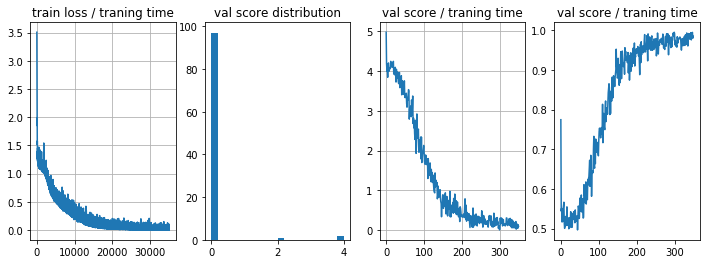

  1%|          | 7/1022 [00:00<00:15, 67.28it/s]

llh=0.020, mean score=0.121, mean bleu=0.984
שיְמֶי -> שימי
כְמִלְתַא -> כמלתא
גַּבֶּךְ -> גבך
וְיִדְאַג -> וידאג
עֻמְרִי -> עמרי
לַחֶלֶב -> לחלב
לְתרי -> לתרי
וִידַהַא -> וידהא
דְּבִרְעוּ -> דברעו
עַנֻגֶּי -> ענגי


100%|██████████| 1022/1022 [00:16<00:00, 62.88it/s]

('Supervised test score:', 0.14109584850246276)


In [42]:
run_model(model, 35000)

Not enough :(

Let's try to change GRU to LSTM cell

In [43]:
# imp.reload(LSTM_model)
from LSTM_model import LSTMTranslationModel
tf.reset_default_graph()
s = tf.InteractiveSession()

model = LSTMTranslationModel('lstm_model', inp_voc, out_voc,
                              emb_size=32, hid_size=64)

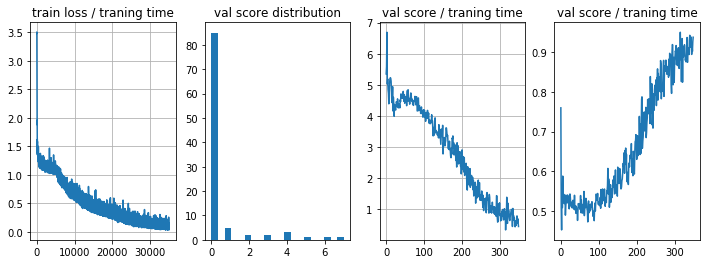

  1%|          | 6/1022 [00:00<00:17, 57.68it/s]

llh=0.074, mean score=0.572, mean bleu=0.922
שיְמֶי -> שימי
כְמִלְתַא -> כמלתא
גַּבֶּךְ -> גבך
וְיִדְאַג -> וידאג
עֻמְרִי -> עמרי
לַחֶלֶב -> לחלב
לְתרי -> לתרי
וִידַהַא -> וידהא
דְּבִרְעוּ -> דברעו
עַנֻגֶּי -> ענגי


100%|██████████| 1022/1022 [00:17<00:00, 59.12it/s]

('Supervised test score:', 0.5641998347967082)


In [44]:
run_model(model, 35000)

This time LSTM is a bit better in llh but worse in mean score, but previous runs GRU was much better than LSTM. Also GRU is a bit simplier, so let's try bidirectional GRU.

In [45]:
# import imp
# imp.reload(GRU_model)
from GRU_model import GRUTranslationModel
tf.reset_default_graph()
s = tf.InteractiveSession()

model = GRUTranslationModel('gru_model_bid', inp_voc, out_voc,
                              emb_size=32, hid_size=64, bidirectional=True)

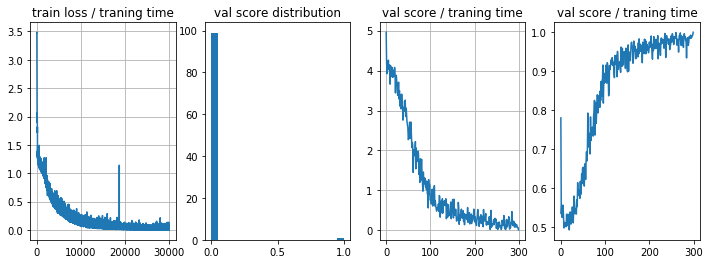

  1%|          | 7/1022 [00:00<00:15, 66.34it/s]

llh=0.014, mean score=0.098, mean bleu=0.989
שיְמֶי -> שימי
כְמִלְתַא -> כמלתא
גַּבֶּךְ -> גבך
וְיִדְאַג -> וידאג
עֻמְרִי -> עמרי
לַחֶלֶב -> לחלב
לְתרי -> לתרי
וִידַהַא -> וידהא
דְּבִרְעוּ -> דברעו
עַנֻגֶּי -> ענגי


100%|██████████| 1022/1022 [00:15<00:00, 66.36it/s]

('Supervised test score:', 0.1200783185976076)


In [46]:
run_model(model, 30000)

Still not enough. Next attemp is Attention based on GRU (first run - bidirectional, second - only forward). As sentences are not very long and we don't have a lot of train data to train all LSTM params, it seems that it should work with GRU.

In [47]:
from Attention_model import AttentionGRUTranslationModel
tf.reset_default_graph()
s = tf.InteractiveSession()

model = AttentionGRUTranslationModel('attention_bidir_gru', inp_voc, out_voc,
                              emb_size=32, hid_size=64, bidirectional=True)

Instructions for updating:
dim is deprecated, use axis instead


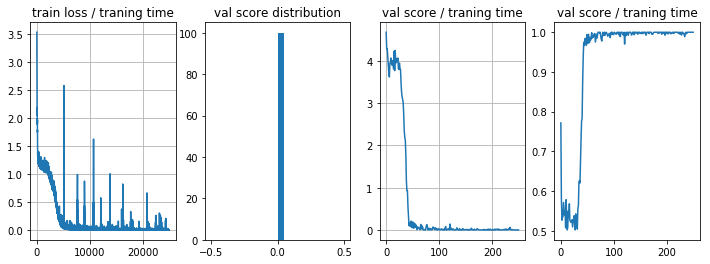

  0%|          | 4/1022 [00:00<00:31, 32.35it/s]

llh=0.000, mean score=0.000, mean bleu=1.000
שיְמֶי -> שימי
כְמִלְתַא -> כמלתא
גַּבֶּךְ -> גבך
וְיִדְאַג -> וידאג
עֻמְרִי -> עמרי
לַחֶלֶב -> לחלב
לְתרי -> לתרי
וִידַהַא -> וידהא
דְּבִרְעוּ -> דברעו
עַנֻגֶּי -> ענגי


100%|██████████| 1022/1022 [00:30<00:00, 33.74it/s]

('Supervised test score:', 0.002355676568666442)


In [48]:
run_model(model)

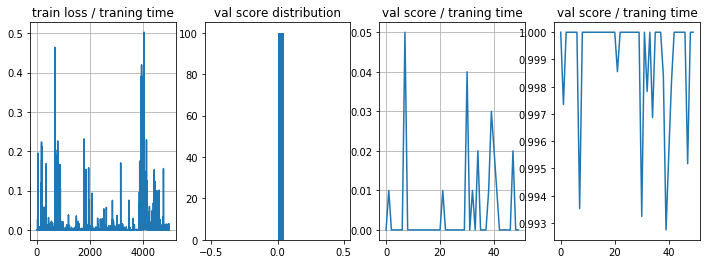

  0%|          | 4/1022 [00:00<00:31, 31.94it/s]

llh=0.004, mean score=0.005, mean bleu=0.999
שיְמֶי -> שימי
כְמִלְתַא -> כמלתא
גַּבֶּךְ -> גבך
וְיִדְאַג -> וידאג
עֻמְרִי -> עמרי
לַחֶלֶב -> לחלב
לְתרי -> לתרי
וִידַהַא -> וידהא
דְּבִרְעוּ -> דברעו
עַנֻגֶּי -> ענגי


100%|██████████| 1022/1022 [00:30<00:00, 33.79it/s]

('Supervised test score:', 0.0021415241533331293)


In [49]:
run_model(model, 5000)

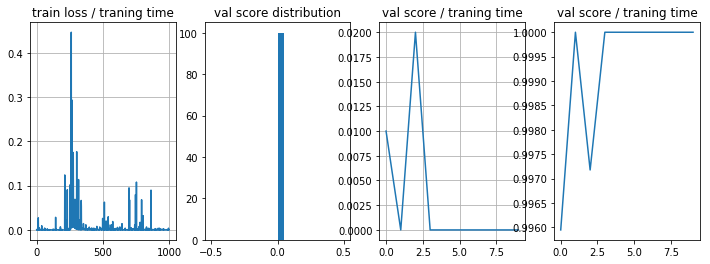

  0%|          | 4/1022 [00:00<00:32, 31.76it/s]

llh=0.001, mean score=0.003, mean bleu=0.999
שיְמֶי -> שימי
כְמִלְתַא -> כמלתא
גַּבֶּךְ -> גבך
וְיִדְאַג -> וידאג
עֻמְרִי -> עמרי
לַחֶלֶב -> לחלב
לְתרי -> לתרי
וִידַהַא -> וידהא
דְּבִרְעוּ -> דברעו
עַנֻגֶּי -> ענגי


100%|██████████| 1022/1022 [00:30<00:00, 33.69it/s]

('Supervised test score:', 0.002325083366475969)


In [50]:
run_model(model, 1000, 1e-4)

Because of oscilating (see it on the plots) have to catch good score. Finally caught it.

# Deal with it!

Let's make some more experiments. At first run only forward GRU.

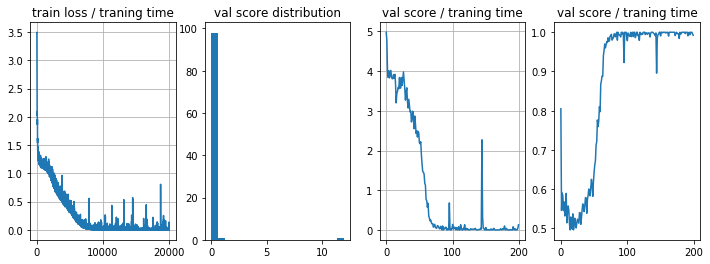

  0%|          | 4/1022 [00:00<00:32, 31.64it/s]

llh=0.005, mean score=0.031, mean bleu=0.997
שיְמֶי -> שימי
כְמִלְתַא -> כמלתא
גַּבֶּךְ -> גבך
וְיִדְאַג -> וידאג
עֻמְרִי -> עמרי
לַחֶלֶב -> לחלב
לְתרי -> לתרי
וִידַהַא -> וידהא
דְּבִרְעוּ -> דברעו
עַנֻגֶּי -> ענגי


100%|██████████| 1022/1022 [00:30<00:00, 33.63it/s]

('Supervised test score:', 0.03830268914247254)


In [51]:
from Attention_model import AttentionGRUTranslationModel
tf.reset_default_graph()
s = tf.InteractiveSession()

model = AttentionGRUTranslationModel('attention_dir_gru', inp_voc, out_voc,
                              emb_size=32, hid_size=64, bidirectional=False)
run_model(model, 20000)

Try random initialization

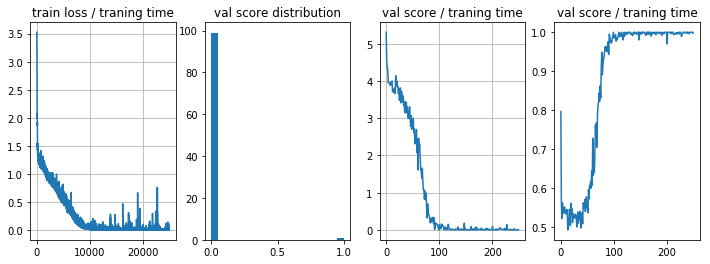

  0%|          | 0/1022 [00:00<?, ?it/s]

llh=0.001, mean score=0.005, mean bleu=0.999
שיְמֶי -> שימי
כְמִלְתַא -> כמלתא
גַּבֶּךְ -> גבך
וְיִדְאַג -> וידאג
עֻמְרִי -> עמרי
לַחֶלֶב -> לחלב
לְתרי -> לתרי
וִידַהַא -> וידהא
דְּבִרְעוּ -> דברעו
עַנֻגֶּי -> ענגי


100%|██████████| 1022/1022 [00:30<00:00, 33.64it/s]

('Supervised test score:', 0.0026310153883807017)


In [52]:
from Attention_model import AttentionGRUTranslationModel
tf.reset_default_graph()
s = tf.InteractiveSession()

model = AttentionGRUTranslationModel('attention_dir_gru', inp_voc, out_voc,
                              emb_size=32, hid_size=64, bidirectional=False, init='random')
run_model(model)

Picture seems to be the same

Finally, let's try to change attention function to tanh

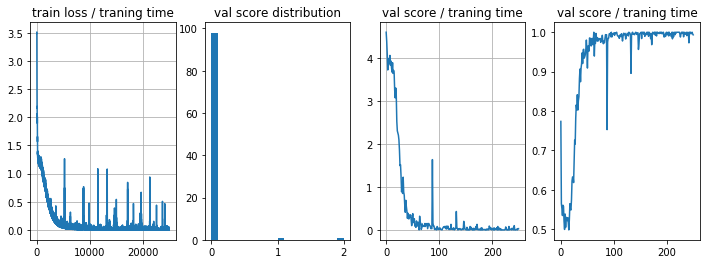

  0%|          | 4/1022 [00:00<00:31, 32.33it/s]

llh=0.003, mean score=0.020, mean bleu=0.995
שיְמֶי -> שימי
כְמִלְתַא -> כמלתא
גַּבֶּךְ -> גבך
וְיִדְאַג -> וידאג
עֻמְרִי -> עמרי
לַחֶלֶב -> לחלב
לְתרי -> לתרי
וִידַהַא -> וידהא
דְּבִרְעוּ -> דברעו
עַנֻגֶּי -> ענגי


100%|██████████| 1022/1022 [00:30<00:00, 33.41it/s]

('Supervised test score:', 0.016122617554379416)


In [53]:
from Attention_model import AttentionGRUTranslationModel
tf.reset_default_graph()
s = tf.InteractiveSession()

model = AttentionGRUTranslationModel('attention_bidir_gru', inp_voc, out_voc,
                              emb_size=32, hid_size=64, bidirectional=True, attention_fun='tanh', init='random')
run_model(model)

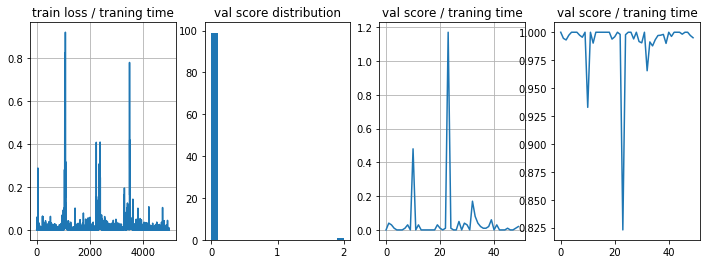

  0%|          | 4/1022 [00:00<00:31, 32.25it/s]

llh=0.002, mean score=0.007, mean bleu=0.999
שיְמֶי -> שימי
כְמִלְתַא -> כמלתא
גַּבֶּךְ -> גבך
וְיִדְאַג -> וידאג
עֻמְרִי -> עמרי
לַחֶלֶב -> לחלב
לְתרי -> לתרי
וִידַהַא -> וידהא
דְּבִרְעוּ -> דברעו
עַנֻגֶּי -> ענגי


100%|██████████| 1022/1022 [00:30<00:00, 33.36it/s]

('Supervised test score:', 0.0073423685257135865)


In [54]:
run_model(model, 5000)

Attention function - simple multiplying h and s.

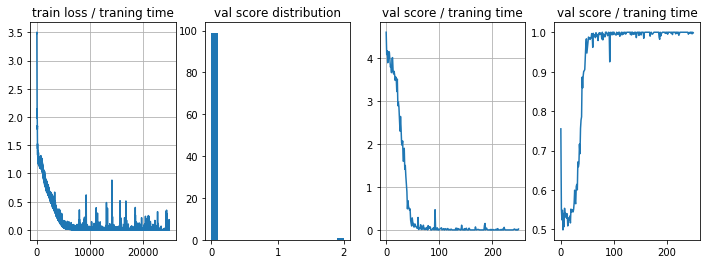

  0%|          | 4/1022 [00:00<00:32, 31.79it/s]

llh=0.001, mean score=0.009, mean bleu=0.998
שיְמֶי -> שימי
כְמִלְתַא -> כמלתא
גַּבֶּךְ -> גבך
וְיִדְאַג -> וידאג
עֻמְרִי -> עמרי
לַחֶלֶב -> לחלב
לְתרי -> לתרי
וִידַהַא -> וידהא
דְּבִרְעוּ -> דברעו
עַנֻגֶּי -> ענגי


100%|██████████| 1022/1022 [00:32<00:00, 31.62it/s]

('Supervised test score:', 0.004313641508856732)


In [55]:
from Attention_model import AttentionGRUTranslationModel
tf.reset_default_graph()
s = tf.InteractiveSession()

model = AttentionGRUTranslationModel('attention_bidir_gru', inp_voc, out_voc,
                              emb_size=32, hid_size=64, bidirectional=True, attention_fun='simple', init='random')
run_model(model)

Another variant of tanh :)

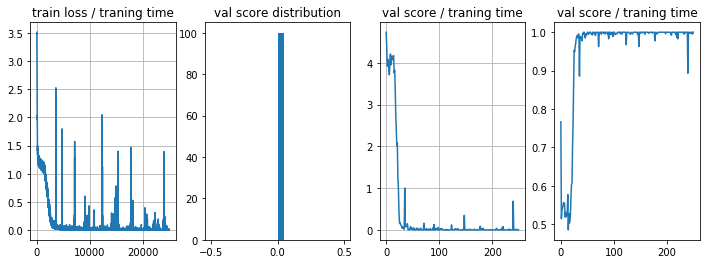

  0%|          | 0/1022 [00:00<?, ?it/s]

llh=0.001, mean score=0.004, mean bleu=0.999
שיְמֶי -> שימי
כְמִלְתַא -> כמלתא
גַּבֶּךְ -> גבך
וְיִדְאַג -> וידאג
עֻמְרִי -> עמרי
לַחֶלֶב -> לחלב
לְתרי -> לתרי
וִידַהַא -> וידהא
דְּבִרְעוּ -> דברעו
עַנֻגֶּי -> ענגי


100%|██████████| 1022/1022 [00:40<00:00, 25.47it/s]

('Supervised test score:', 0.001988558142380763)


In [56]:
from Attention_model import AttentionGRUTranslationModel
tf.reset_default_graph()
s = tf.InteractiveSession()

model = AttentionGRUTranslationModel('attention_bidir_gru', inp_voc, out_voc,
                              emb_size=32, hid_size=64, bidirectional=True, attention_fun='tanh_hard', init='random')
run_model(model)

Final conclusion - Attention is all you need :) works well enough both with GRU forward and bidirectional and more or less good enough with different functions inside. It's hard to  get the same score with hard_mode.

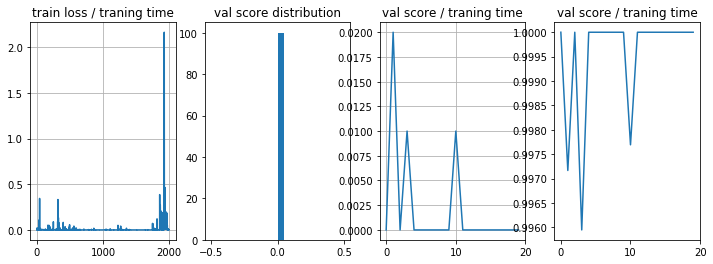

  0%|          | 0/1022 [00:00<?, ?it/s]

llh=0.003, mean score=0.001, mean bleu=1.000
שיְמֶי -> שימי
כְמִלְתַא -> כמלתא
גַּבֶּךְ -> גבך
וְיִדְאַג -> וידאג
עֻמְרִי -> עמרי
לַחֶלֶב -> לחלב
לְתרי -> לתרי
וִידַהַא -> וידהא
דְּבִרְעוּ -> דברעו
עַנֻגֶּי -> ענגי


100%|██████████| 1022/1022 [00:42<00:00, 23.81it/s]

('Supervised test score:', 0.006179826842475602)


In [57]:
run_model(model, 2000)

`[your report/log here or anywhere you please]`